<a href="https://colab.research.google.com/github/Rudi3601/CHC_Thesis/blob/main/DeepHedging(Exotic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [ ]:
#%tensorflow_version 1.x
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

#from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt

import copy


Parameters for Look-back Options and price simulations based on GBM

In [ ]:
# Trajectories of the Black scholes model
# Let it run to initialize the following parameters, the trajectories
# are not needed afterwards

N=100 # time disrectization
S0=1 # initial value of the asset
X0=1  # initial wealth
T=1 # maturity
sigma=0.2 # volatility in Black Scholes
mu=0.1
r=0.1
gamma=0.0
R=10**5 # number of Trajectories

logS= np.zeros((N,R))
logS[0,]=np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(mu*T/N-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] =logS[j,i]+increment

S=np.exp(logS)
print(S)

strike = np.min(S)
print(strike)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.97821121 0.95451247 0.99595778 ... 1.01272415 1.01809086 0.96792736]
 [0.96911302 0.90312996 1.01555094 ... 1.01848541 1.03683806 0.94454526]
 ...
 [0.87697645 0.91632138 1.16535748 ... 1.06099098 0.92379616 1.42091679]
 [0.87085098 0.91198902 1.18907378 ... 1.07962874 0.91934239 1.38607776]
 [0.87985806 0.89756769 1.19752996 ... 1.07163938 0.91402949 1.38125292]]
0.46914217141251763


Price of look-back options

In [ ]:
import math
from scipy.stats import norm

def lookback_call_option(S, t, r, sigma, m):
  tau = T - t
  a1 = (math.log(S / m) + (r + (sigma**2)/2) * tau) / (sigma * tau)
  a2 = a1 - sigma * math.sqrt(tau)
  a3 = a1 - (2 * r * math.sqrt(T))/sigma

  price = S * norm.cdf(a1) - m * math.exp(-r * tau) * norm.cdf(a2) - (S*(sigma**2)/(2*r))*(-norm.cdf(a1) - (math.exp(-r * tau) * math.exp(m / S)) * norm.cdf(-a3))

  return price

price_option = lookback_call_option(S0, 0, r, sigma, strike)

Definition of Neural networks

In [ ]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

Implementing the Loss Function

In [ ]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0,
#the initial hedging being 0, and the increments of the log price process
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
print(inputs)
outputhelper=[]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    strategyeval=hedgeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price)
outputs = Subtract()([payoff,hedge])
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge
outputs= [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_137')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_138')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_139')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_140')>]


In [ ]:
R=50 # reduction
# architecture is the same for all networks
layers_red = []
for j in range(R):
    for i in range(d):
        if i < d-1:
            nodes_red = n
            layer_red = Dense(nodes_red, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes_red = m
            layer_red = Dense(nodes_red, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers_red = layers_red + [layer_red]

for j in range(R,N):
    for i in range(d):
        if i < d-1:
            nodes_red = n
            layer_red = Dense(nodes_red, activation='tanh',trainable=False,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes_red = m
            layer_red = Dense(nodes_red, activation='linear', trainable=False,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers_red = layers_red + [layer_red]

Implementing Loss Function

In [ ]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0,
#the initial hedging being 0, and the increments of the log price process
price_red = Input(shape=(m,))
hedge_red = Input(shape=(m,))
hedgeeval_red = Input(shape=(m,))
premium_red = Input(shape=(m,))

inputs_red = [price_red]+[hedge_red]+[hedgeeval_red]+[premium_red]
outputhelper_red=[]

premium_red = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium_red)

for j in range(N):
    strategy_red = price_red
    strategyeval_red=hedgeeval_red
    for k in range(d):
        strategy_red= layers_red[k+(j)*d](strategy_red) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval_red=layers_red[k+(j)*d](strategyeval_red)
    incr_red = Input(shape=(m,))
    logprice_red= Lambda(lambda x : K.log(x))(price_red)
    logprice_red = Add()([logprice_red, incr_red])
    pricenew_red=Lambda(lambda x : K.exp(x))(logprice_red)# creating the price at time j+1
    priceincr_red=Subtract()([pricenew_red, price_red])
    hedgenew_red = Multiply()([strategy_red, priceincr_red])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge_red = Add()([hedge_red,hedgenew_red]) # building up the discretized stochastic integral
    inputs_red = inputs_red + [incr_red]
    outputhelper_red = outputhelper_red + [strategyeval_red]
    price_red=pricenew_red
payoff_red= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price_red)
outputs_red = Subtract()([payoff_red,hedge_red])
outputs_red = Subtract()([outputs_red,premium_red]) # payoff minus price minus hedge
outputs_red= [outputs_red] + outputhelper_red +[premium_red]
outputs_red = Concatenate()(outputs_red)

model_hedge_strat_red = Model(inputs=inputs_red, outputs=outputs_red)

In [ ]:
gamma = 1.0
grid = [(i/N)**gamma*T for i in range(N+1)]

Ktrain = 10**5
initialprice = S0

# xtrain consists of the price S0,
#the initial hedging being 0, and the increments of the log price process
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [price_option*np.ones((Ktrain,m))]+
          [np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]),sigma*np.sqrt(grid[i+1]-grid[i]),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [ ]:
N_red=100000
xtrain_red=copy.deepcopy(xtrain)
for i in range(R):
    a = xtrain_red[4+i]
    for k in range(int(Ktrain/N_red)):
        for l in range(N_red):
            a[k*N_red+l,:]=a[k*N_red,:]
    xtrain_red[4+i]=a

In [ ]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.square(z))
    return z


In [ ]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)
model_hedge_strat_red.compile(optimizer='adam',loss=custom_loss)

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True,batch_size=100)
weights = model_hedge_strat.get_weights()
model_hedge_strat_red.set_weights(weights)
#for i in range(5):
#    model_hedge_strat_red.fit(x=xtrain_red,y=ytrain, epochs=1,verbose=True,batch_size=10000)
#weights = model_hedge_strat_red.get_weights()
#model_hedge_strat.set_weights(weights)

1000/1000 [==============================] - 55s 55ms/step - loss: 2.9637e-06


3125/3125 [==============================] - 52s 15ms/step


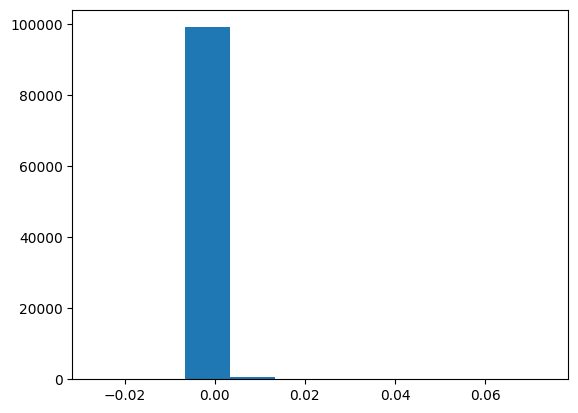

0.0014202839
0.5308246


In [ ]:
a = model_hedge_strat.predict(xtrain)
plt.hist(a[:,0])
plt.show()
print(np.std(a[:,0]))
print(np.mean(a[:,N+1]))

In [ ]:
Ktest=50
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [0.5*np.ones((Ktest,m))+np.cumsum(np.ones((Ktest,m))*(1.5-0.5)/Ktest,axis=0)] +#change this if you go to higher dimensions
          [price_option*np.ones((Ktest,m))]+
          [np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]),sigma*np.sqrt(grid[i+1]-grid[i]),(Ktest,m)) for i in range(N)])

y=model_hedge_strat.predict(xtest)[:,10]
print(y)

2/2 [==============================] - 6s 26ms/step
[0.9459044  0.95112544 0.95589435 0.9602582  0.96425796 0.967929
 0.9713029  0.9744061  0.9772623  0.9798914  0.9823113  0.98453695
 0.98658174 0.9884571  0.9901727  0.9917373  0.9931581  0.99444157
 0.9955928  0.99661654 0.99751645 0.99829614 0.99895746 0.99950343
 0.9999351  1.0002539  1.0004609  1.0005566  1.0005416  1.0004158
 1.0001795  0.9998326  0.99937516 0.9988068  0.99812734 0.9973366
 0.99643445 0.9954208  0.9942956  0.9930589  0.99171096 0.9902522
 0.98868257 0.9870034  0.98521477 0.9833179  0.98131365 0.9792033
 0.976988   0.9746695 ]


In [ ]:
import scipy.stats as scipy
from scipy.stats import norm
logincrements = xtrain[4:4+N]
hedge = np.zeros(Ktrain)
price = S0*np.ones((Ktrain,N))
for k in range(N-1):
    helper = logincrements[k][:,]
    helper = helper.transpose()
    price[:,k+1] = price[:,k]*np.exp(helper[:])
    hedge[:] = hedge[:] + scipy.norm.cdf((np.log(price[:,k]/strike)+0.5*(T-grid[k+1])*sigma**2)/(np.sqrt(T-grid[k+1])*sigma))*(price[:,k+1]-price[:,k])
hedge[:]= hedge[:]-0.5*(np.abs(price[:,N-1]-strike)+(price[:,N-1]-strike))+price
plt.hist(hedge)
plt.show()
print(np.std(hedge))
print(np.mean(hedge))

ValueError: operands could not be broadcast together with shapes (100000,) (100000,100) 

2/2 [==============================] - 0s 17ms/step


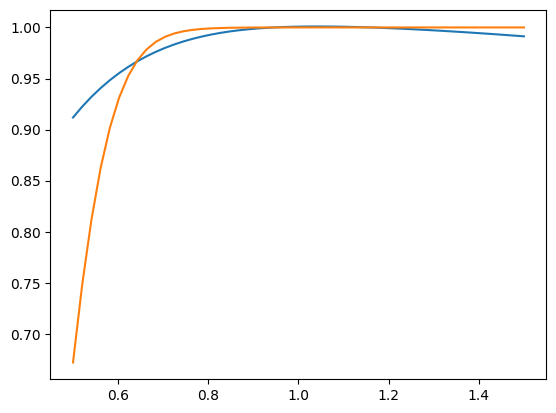

In [ ]:
from scipy.stats import norm
l =20
s=np.linspace(0.5,1.5,Ktest)
z=scipy.norm.cdf((np.log(s/strike)+0.5*(T-grid[l])*sigma**2)/(np.sqrt(T-grid[l])*sigma))
#plt.plot(s,z)
#plt.plot(s,y)
y=model_hedge_strat.predict(xtest)[:,l]
plt.plot(s,y,s,z)
plt.show()